Paired TAM (transcient abnormal myleoproliferation) vs AML (acute myeloid leukemia) analysis of patients with the co-occuring condition of Down Syndrome using DESeq2 on IJC counts obtained from rMATS analysis.

Using a matrix constructed from Kids First Workflow V4 done on single runs, a post-rMATS-single-run prepareSEfiles.sh was run that created a bed file for visualizaiton in UCSC Genome browser of all the events, as well as created a matrix of the single runs normalized to the non-redundant union of files.  Using associative arrays in an awk script, it was a rapid way to transform the individual counts from each of the individual runs into a matrix that facilitated analysis.

Using annotations obtained from the rMATS run that provided the coordinates of each of the splicing events as well as the gene that the junctions came from and the count of the reads that overlapped the junctions.   
 
We will use DESeq2 to perform analysis of these junction counts in the identical way that a gene analysis would be completed.

This allows us to take advantage of the gene-specific shrinkage approach employed by DESeq2 for these junctions.

We will use BiocManager to manage the installation of the Bioconductor package, DeSeq2

In [1]:
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager", repos = "https://cloud.r-project.org")

BiocManager::install("DESeq2")


'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.17 (BiocManager 1.30.21.1), R 4.3.1 (2023-06-16)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'DESeq2'”
Old packages: 'openssl', 'S4Arrays'



In [2]:
setwd("../data/")


In [3]:
getwd()


[1] "/Users/annedeslattesmays/Desktop/projects/rmats-ijc-analysis/data"

In [4]:
cts <- system.file("SE.IJC.paired.TAM.AML.csv")


In [5]:
anno <- system.file("SE.coordinates.matrix.csv")

In [6]:
cts <- as.matrix(read.csv("SE.IJC.paired.TAM.AML.csv",sep=",",row.names="ID"))

In [7]:
head(cts,2)

,PAUVKY.03A,PAUVKY.40A,PAWSNZ.03A,PAWSNZ.40A,PAUTLA.03A,PAUTLA.40A,PAVUDU.03A,PAVUDU.40A
1,9,15,17,0,44,17,33,19
2,22,19,9,16,26,11,26,17


In [8]:
annot <- read.csv("SE.coordinates.matrix.csv",sep=",",row.names=1)

In [12]:
head (annot,2)


,GeneID,geneSymbol,chr,strand,exonStart_0base,exonEnd,upstreamES,upstreamEE,downstreamES,downstreamEE
,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>
1,ENSG00000117620.15,SLC35A3,chr1,+,100007033,100007156,99993536,99993741,100009287,100009323
2,ENSG00000117620.15,SLC35A3,chr1,+,100007033,100007156,99993536,99993741,100011364,100011533


In [10]:
coldata <- read.csv("design_matrix.csv",row.names=1)

In [11]:
coldata


,condition
,<chr>
PAUVKY-03A,TAM
PAUVKY-40A,AML
PAWSNZ-03A,TAM
PAWSNZ-40A,AML
PAUTLA-03A,TAM
PAUTLA-40A,AML
PAVUDU-03A,TAM
PAVUDU-40A,AML


In [13]:
rownames(coldata)

[1] "PAUVKY-03A" "PAUVKY-40A" "PAWSNZ-03A" "PAWSNZ-40A" "PAUTLA-03A"
[6] "PAUTLA-40A" "PAVUDU-03A" "PAVUDU-40A"

In [14]:
rownames(coldata) <-sub("-",".",rownames(coldata))

In [15]:
colnames(cts)

[1] "PAUVKY.03A" "PAUVKY.40A" "PAWSNZ.03A" "PAWSNZ.40A" "PAUTLA.03A"
[6] "PAUTLA.40A" "PAVUDU.03A" "PAVUDU.40A"

In [16]:
all(rownames(coldata) %in% colnames(cts))



[1] TRUE

In [17]:
library("DESeq2")
dds <- DESeqDataSetFromMatrix(countData = cts,
                              colData = coldata,
                              design = ~ condition)
dds

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomicRanges

Loading required package: GenomeInfoDb

Loa

class: DESeqDataSet 
dim: 106443 8 
metadata(1): version
assays(1): counts
rownames(106443): 1 2 ... 106442 106443
rowData names(0):
colnames(8): PAUVKY.03A PAUVKY.40A ... PAVUDU.03A PAVUDU.40A
colData names(1): condition

In [18]:
featureData <- data.frame(gene=rownames(cts))

In [19]:
mcols(dds) <- DataFrame(mcols(dds), featureData)
mcols(dds)


DataFrame with 106443 rows and 1 column
              gene
       <character>
1                1
2                2
3                3
4                4
5                5
...            ...
106439      106439
106440      106440
106441      106441
106442      106442
106443      106443

In [20]:
keep <- rowSums(counts(dds)) >= 10
dds <- dds[keep,]

In [21]:
head(cts,2)

,PAUVKY.03A,PAUVKY.40A,PAWSNZ.03A,PAWSNZ.40A,PAUTLA.03A,PAUTLA.40A,PAVUDU.03A,PAVUDU.40A
1,9,15,17,0,44,17,33,19
2,22,19,9,16,26,11,26,17


In [22]:
dds$condition <- factor(dds$condition, levels = c("TAM","AML"))

In [23]:
dds <- DESeq(dds)
res <- results(dds, contrast=c("condition","TAM","AML"))
res

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



log2 fold change (MLE): condition TAM vs AML 
Wald test p-value: condition TAM vs AML 
DataFrame with 91382 rows and 6 columns
        baseMean log2FoldChange     lfcSE       stat    pvalue      padj
       <numeric>      <numeric> <numeric>  <numeric> <numeric> <numeric>
1        17.2551       0.643823   1.76687  0.3643864  0.715570         1
2        18.1188      -0.104310   1.52240 -0.0685168  0.945374         1
3        19.3328      -0.329952   2.58598 -0.1275923  0.898472         1
4        39.2457      -0.525557   1.46133 -0.3596429  0.719114         1
5        31.3118      -0.161779   1.49647 -0.1081069  0.913911         1
...          ...            ...       ...        ...       ...       ...
106438  26.09071      -22.10746   3.31733   -6.66423        NA        NA
106439   1.35185       -4.14694   3.41734   -1.21350  0.224939        NA
106441   1.48704       -4.28390   3.41428   -1.25470  0.209588        NA
106442   1.62222       -4.40898   3.41173   -1.29230  0.196254        

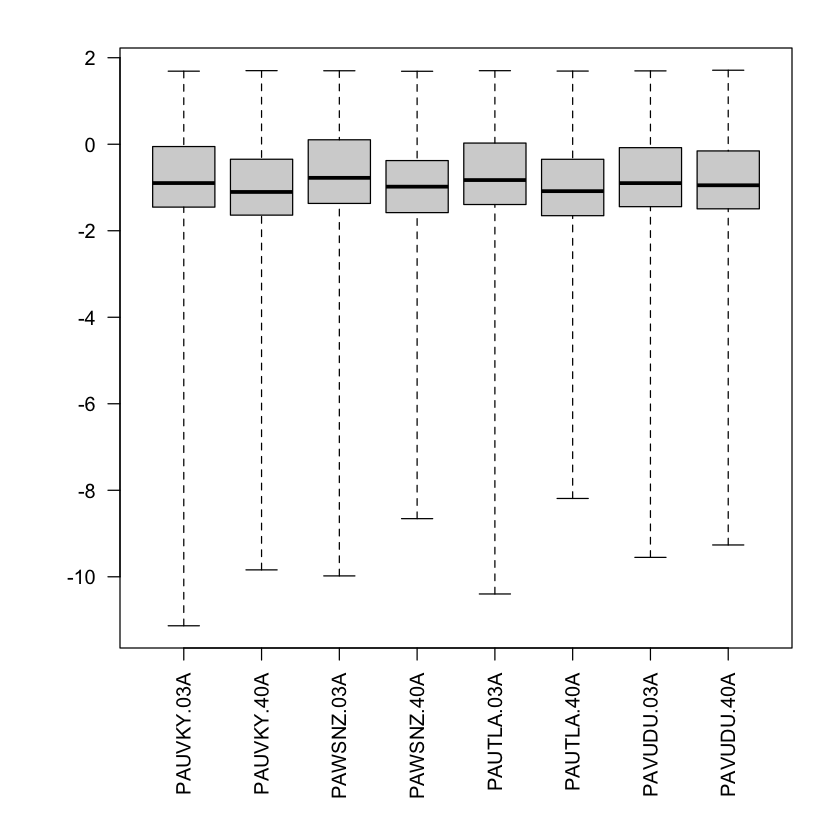

In [24]:
par(mar=c(8,5,2,2))
boxplot(log10(assays(dds)[["cooks"]]), range=0, las=2)

In [26]:
library("pheatmap")
select <- order(rowMeans(counts(dds,normalized=TRUE)),
                decreasing=TRUE)[1:20]
df <- as.data.frame(colData(dds)[,c("condition")])
pheatmap(assay(ntd)[select,], cluster_rows=FALSE, show_rownames=FALSE,
         cluster_cols=FALSE, annotation_col=df)


ERROR: Error in library("pheatmap"): there is no package called ‘pheatmap’
